In [1]:
import HARK.ConsumptionSaving.ConsumerParameters as Params
import matplotlib.pyplot as plt
from HARK.utilities import plotFuncs
from time import process_time
import numpy as np
from HARK.ConsumptionSaving.ConsPrefShockModel import (
    PrefShockConsumerType,
    KinkyPrefConsumerType,
)
mystr = lambda number: "{:.4f}".format(number)
do_simulation = True

In [2]:
# Make and solve a preference shock consumer
PrefShockExample = PrefShockConsumerType()
PrefShockExample.cycles = 0  # Infinite horizon

In [3]:
t_start = process_time()
PrefShockExample.solve()
t_end = process_time()
print("Solving a preference shock consumer took " + str(t_end - t_start) + " seconds.")

Solving a preference shock consumer took 0.8477220000000001 seconds.


Consumption functions at each discrete shock:


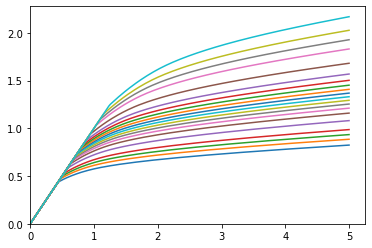

In [4]:
# Plot the consumption function at each discrete shock
m = np.linspace(PrefShockExample.solution[0].mNrmMin, 5, 200)
print("Consumption functions at each discrete shock:")
for j in range(PrefShockExample.PrefShkDstn[0][1].size):
    PrefShk = PrefShockExample.PrefShkDstn[0][1][j]
    c = PrefShockExample.solution[0].cFunc(m, PrefShk * np.ones_like(m))
    plt.plot(m, c)
plt.xlim([0.0, None])
plt.ylim([0.0, None])
plt.show()

Consumption function (and MPC) when shock=1:


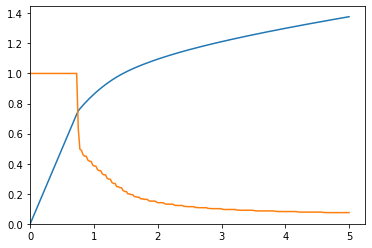

In [5]:
print("Consumption function (and MPC) when shock=1:")
c = PrefShockExample.solution[0].cFunc(m, np.ones_like(m))
k = PrefShockExample.solution[0].cFunc.derivativeX(m, np.ones_like(m))
plt.plot(m, c)
plt.plot(m, k)
plt.xlim([0.0, None])
plt.ylim([0.0, None])
plt.show()

In [6]:
if PrefShockExample.vFuncBool:
    print("Value function (unconditional on shock):")
    plotFuncs(
        PrefShockExample.solution[0].vFunc,
        PrefShockExample.solution[0].mNrmMin + 0.5,
        5,
    )

In [7]:
# Test the simulator for the pref shock class
if do_simulation:
    PrefShockExample.T_sim = 120
    PrefShockExample.track_vars = ["cNrmNow"]
    PrefShockExample.makeShockHistory()  # This is optional
    PrefShockExample.initializeSim()
    PrefShockExample.simulate()

In [8]:
# Make and solve a "kinky preferece" consumer, whose model combines KinkedR and PrefShock
KinkyPrefExample = KinkyPrefConsumerType()
KinkyPrefExample.cycles = 0  # Infinite horizon

In [9]:
t_start = process_time()
KinkyPrefExample.solve()
t_end = process_time()
print("Solving a kinky preference consumer took " + str(t_end - t_start) + " seconds.")

Solving a kinky preference consumer took 1.006215 seconds.


Consumption functions at each discrete shock:


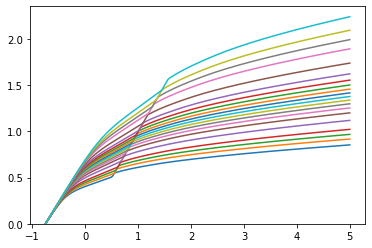

In [10]:
# Plot the consumption function at each discrete shock
m = np.linspace(KinkyPrefExample.solution[0].mNrmMin, 5, 200)
print("Consumption functions at each discrete shock:")
for j in range(KinkyPrefExample.PrefShkDstn[0][1].size):
    PrefShk = KinkyPrefExample.PrefShkDstn[0][1][j]
    c = KinkyPrefExample.solution[0].cFunc(m, PrefShk * np.ones_like(m))
    plt.plot(m, c)
plt.ylim([0.0, None])
plt.show()

Consumption function (and MPC) when shock=1:


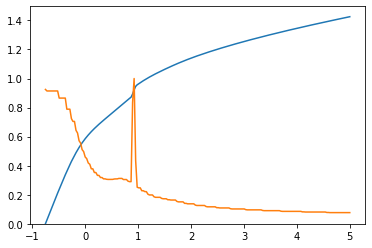

In [11]:
print("Consumption function (and MPC) when shock=1:")
c = KinkyPrefExample.solution[0].cFunc(m, np.ones_like(m))
k = KinkyPrefExample.solution[0].cFunc.derivativeX(m, np.ones_like(m))
plt.plot(m, c)
plt.plot(m, k)
plt.ylim([0.0, None])
plt.show()

In [12]:
if KinkyPrefExample.vFuncBool:
    print("Value function (unconditional on shock):")
    plotFuncs(
        KinkyPrefExample.solution[0].vFunc,
        KinkyPrefExample.solution[0].mNrmMin + 0.5,
        5,
    )

In [13]:
# Test the simulator for the kinky preference class
if do_simulation:
    KinkyPrefExample.T_sim = 120
    KinkyPrefExample.track_vars = ["cNrmNow", "PrefShkNow"]
    KinkyPrefExample.initializeSim()
    KinkyPrefExample.simulate()